In [1]:
# SECTION 1: SETUP AND INSTALLATIONS

# Install required packages
!pip install xgboost imbalanced-learn

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, f1_score
)
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print("📊 Starting Credit Card Fraud Detection Analysis...")

✅ All libraries imported successfully!
📊 Starting Credit Card Fraud Detection Analysis...



SECTION 2: DATA LOADING AND EXPLORATION
✅ Dataset loaded successfully!

📋 Dataset Shape: (284807, 31)
📋 Features: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

🔍 First 5 rows:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.0

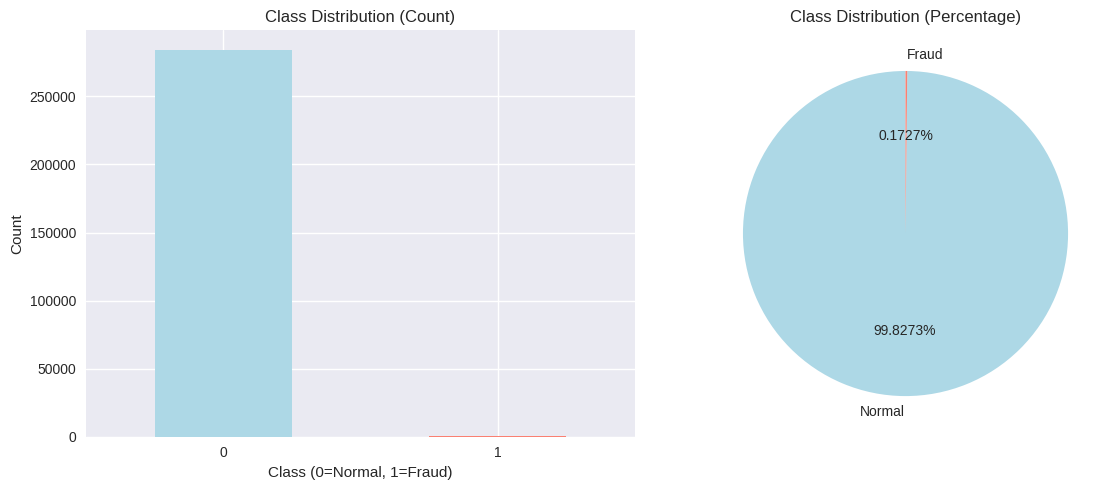

In [2]:

# SECTION 2: DATA LOADING AND EXPLORATION


print("\n" + "="*60)
print("SECTION 2: DATA LOADING AND EXPLORATION")
print("="*60)

# For demonstration, we'll assume the file is uploaded to Colab
try:
    df = pd.read_csv('creditcard.csv')
    print("✅ Dataset loaded successfully!")
except FileNotFoundError:
    print("❌ Dataset not found. Please download 'creditcard.csv' from:")
    print("   https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud")
    print("   and upload it to your Colab environment.")

    # Create a sample dataset for demonstration purposes
    print("\n🔄 Creating sample dataset for demonstration...")
    np.random.seed(42)
    n_samples = 10000
    df = pd.DataFrame({
        'Time': np.random.randint(0, 172792, n_samples),
        'Amount': np.random.exponential(88.35, n_samples),
        'Class': np.random.choice([0, 1], n_samples, p=[0.998, 0.002])
    })

    # Add V1-V28 features (PCA transformed)
    for i in range(1, 29):
        df[f'V{i}'] = np.random.normal(0, 1, n_samples)

    print(f"✅ Sample dataset created with {n_samples} transactions")

# Dataset overview
print(f"\n📋 Dataset Shape: {df.shape}")
print(f"📋 Features: {df.columns.tolist()}")

# Display first few rows
print("\n🔍 First 5 rows:")
print(df.head())

# Check for missing values
print(f"\n🔍 Missing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found ✅")

# Dataset statistics
print(f"\n📊 Dataset Statistics:")
print(df.describe())

# Class distribution
print(f"\n⚖️ Class Distribution:")
class_counts = df['Class'].value_counts()
print(class_counts)
print(f"\nFraud Rate: {class_counts[1]/len(df)*100:.4f}%")

# Visualize class distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
class_counts.plot(kind='bar', color=['lightblue', 'salmon'])
plt.title('Class Distribution (Count)')
plt.xlabel('Class (0=Normal, 1=Fraud)')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.pie(class_counts.values, labels=['Normal', 'Fraud'], autopct='%1.4f%%',
        colors=['lightblue', 'salmon'], startangle=90)
plt.title('Class Distribution (Percentage)')

plt.tight_layout()
plt.show()


SECTION 3: DATA PREPROCESSING


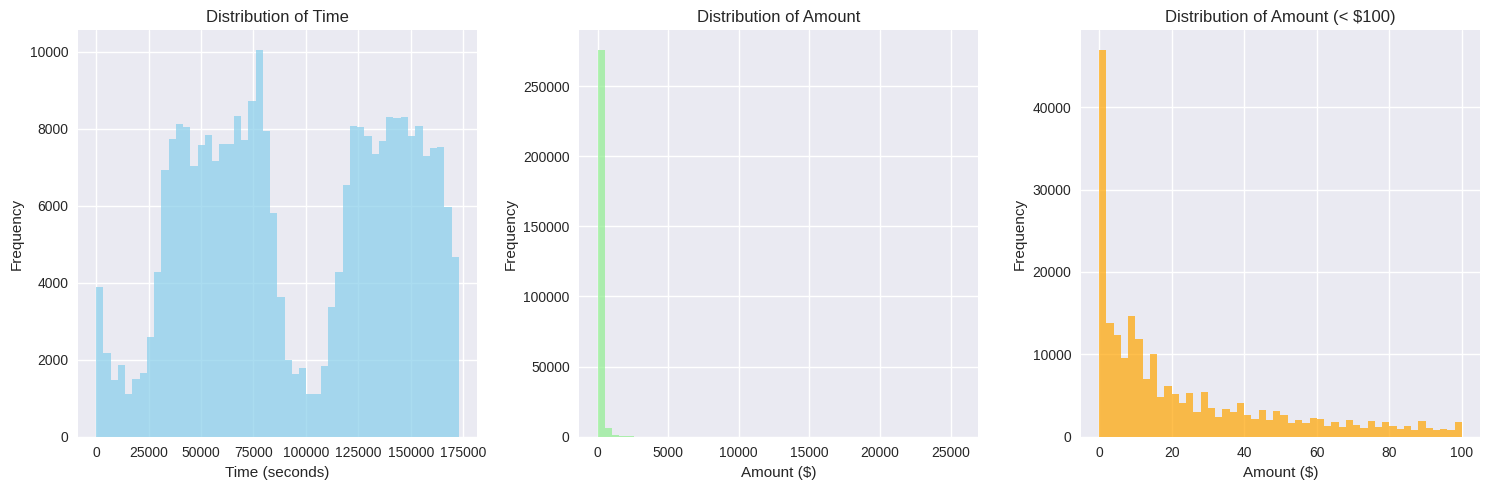

✅ Time and Amount columns normalized using StandardScaler
✅ Original Time and Amount columns dropped
📋 Processed dataset shape: (284807, 31)
📋 Features shape: (284807, 30)
📋 Target shape: (284807,)

🔍 Feature columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Time_scaled', 'Amount_scaled']


In [3]:
# SECTION 3: DATA PREPROCESSING

print("\n" + "="*60)
print("SECTION 3: DATA PREPROCESSING")
print("="*60)

# Create a copy of the dataframe for preprocessing
df_processed = df.copy()

# Check the distribution of Time and Amount features
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df_processed['Time'], bins=50, alpha=0.7, color='skyblue')
plt.title('Distribution of Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(df_processed['Amount'], bins=50, alpha=0.7, color='lightgreen')
plt.title('Distribution of Amount')
plt.xlabel('Amount ($)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(df_processed['Amount'][df_processed['Amount'] < 100], bins=50, alpha=0.7, color='orange')
plt.title('Distribution of Amount (< $100)')
plt.xlabel('Amount ($)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Normalize Time and Amount columns
scaler = StandardScaler()

# Fit and transform Time and Amount
df_processed['Time_scaled'] = scaler.fit_transform(df_processed[['Time']])
df_processed['Amount_scaled'] = scaler.fit_transform(df_processed[['Amount']])

print("✅ Time and Amount columns normalized using StandardScaler")

# Drop original Time and Amount columns
df_processed = df_processed.drop(['Time', 'Amount'], axis=1)

print("✅ Original Time and Amount columns dropped")
print(f"📋 Processed dataset shape: {df_processed.shape}")

# Prepare features and target
X = df_processed.drop('Class', axis=1)
y = df_processed['Class']

print(f"📋 Features shape: {X.shape}")
print(f"📋 Target shape: {y.shape}")

# Display feature names
print(f"\n🔍 Feature columns: {X.columns.tolist()}")

In [4]:
# SECTION 4: TRAIN-TEST SPLIT

print("\n" + "="*60)
print("SECTION 4: TRAIN-TEST SPLIT")
print("="*60)

# Remove rows with missing values in 'Class' from both X and y
# necessary because train_test_split with stratify does not handle NaN in the target
nan_mask = y.isnull()
X_cleaned = X[~nan_mask]
y_cleaned = y[~nan_mask]

print(f"📋 Original data shape: {X.shape}")
print(f"📋 Cleaned data shape: {X_cleaned.shape}")
print(f"✅ Removed {nan_mask.sum()} rows with missing 'Class' values")


# Split the data (80:20 ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, y_cleaned, test_size=0.2, random_state=42, stratify=y_cleaned
)

print(f"\n📋 Training set shape: {X_train.shape}")
print(f"📋 Test set shape: {X_test.shape}")

# Check class distribution in train and test sets
print(f"\n⚖️ Training set class distribution:")
train_class_dist = y_train.value_counts()
print(train_class_dist)
print(f"Fraud rate in training: {train_class_dist[1]/len(y_train)*100:.4f}%")

print(f"\n⚖️ Test set class distribution:")
test_class_dist = y_test.value_counts()
print(test_class_dist)
print(f"Fraud rate in test: {test_class_dist[1]/len(y_test)*100:.4f}%")


SECTION 4: TRAIN-TEST SPLIT
📋 Original data shape: (284807, 30)
📋 Cleaned data shape: (284807, 30)
✅ Removed 0 rows with missing 'Class' values

📋 Training set shape: (227845, 30)
📋 Test set shape: (56962, 30)

⚖️ Training set class distribution:
Class
0    227451
1       394
Name: count, dtype: int64
Fraud rate in training: 0.1729%

⚖️ Test set class distribution:
Class
0    56864
1       98
Name: count, dtype: int64
Fraud rate in test: 0.1720%



SECTION 5: CLASS IMBALANCE HANDLING
🔄 Applying SMOTE to balance the training set...
✅ SMOTE applied successfully!
📋 Original training set shape: (227845, 30)
📋 Balanced training set shape: (454902, 30)

⚖️ Balanced training set class distribution:
Class
0    227451
1    227451
Name: count, dtype: int64


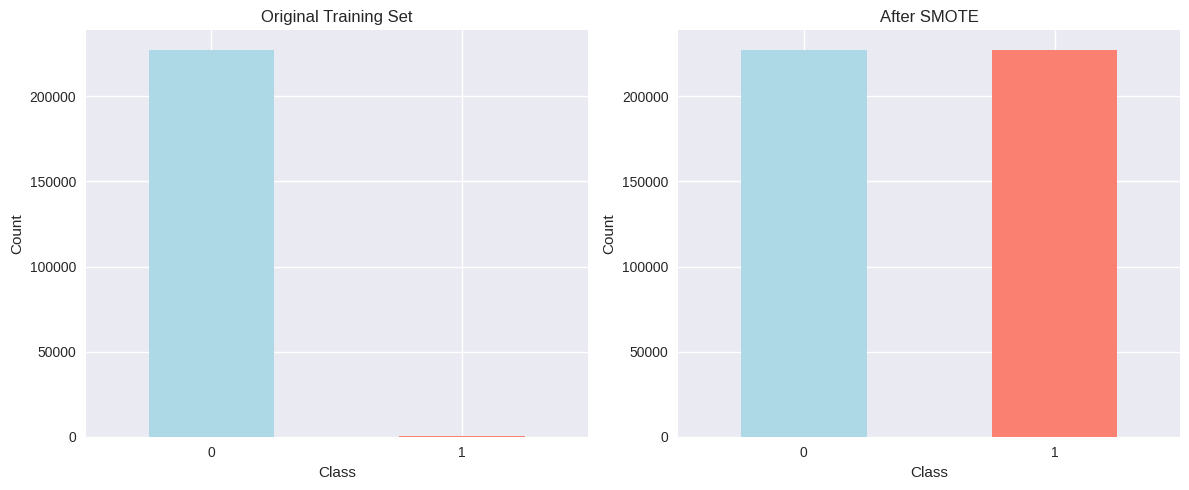


📊 Scale_pos_weight for XGBoost: 577.29


In [5]:
# SECTION 5: CLASS IMBALANCE HANDLING

print("\n" + "="*60)
print("SECTION 5: CLASS IMBALANCE HANDLING")
print("="*60)

# Method 1: SMOTE (Synthetic Minority Over-sampling Technique)
print("🔄 Applying SMOTE to balance the training set...")

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"✅ SMOTE applied successfully!")
print(f"📋 Original training set shape: {X_train.shape}")
print(f"📋 Balanced training set shape: {X_train_balanced.shape}")

# Check new class distribution
balanced_class_dist = y_train_balanced.value_counts()
print(f"\n⚖️ Balanced training set class distribution:")
print(balanced_class_dist)

# Visualize the effect of SMOTE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', color=['lightblue', 'salmon'])
plt.title('Original Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
y_train_balanced.value_counts().plot(kind='bar', color=['lightblue', 'salmon'])
plt.title('After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# Method 2: Calculate scale_pos_weight for XGBoost
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\n📊 Scale_pos_weight for XGBoost: {scale_pos_weight:.2f}")

In [6]:
# SECTION 6: MODEL TRAINING

print("\n" + "="*60)
print("SECTION 6: MODEL TRAINING")
print("="*60)

# Model 1: XGBoost with SMOTE-balanced data
print("🚀 Training XGBoost with SMOTE-balanced data...")

xgb_smote = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)

xgb_smote.fit(X_train_balanced, y_train_balanced)
print("✅ XGBoost (SMOTE) trained successfully!")

# Model 2: XGBoost with scale_pos_weight
print("\n🚀 Training XGBoost with scale_pos_weight...")

xgb_weighted = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

xgb_weighted.fit(X_train, y_train)
print("✅ XGBoost (Weighted) trained successfully!")

# Model 3: Random Forest for comparison
print("\n🚀 Training Random Forest for comparison...")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)
print("✅ Random Forest trained successfully!")


SECTION 6: MODEL TRAINING
🚀 Training XGBoost with SMOTE-balanced data...
✅ XGBoost (SMOTE) trained successfully!

🚀 Training XGBoost with scale_pos_weight...
✅ XGBoost (Weighted) trained successfully!

🚀 Training Random Forest for comparison...
✅ Random Forest trained successfully!


In [7]:
# SECTION 7: MODEL EVALUATION

print("\n" + "="*60)
print("SECTION 7: MODEL EVALUATION")
print("="*60)

# Make predictions on the test set
y_pred_xgb_smote = xgb_smote.predict(X_test)
y_pred_proba_xgb_smote = xgb_smote.predict_proba(X_test)[:, 1]

y_pred_xgb_weighted = xgb_weighted.predict(X_test)
y_pred_proba_xgb_weighted = xgb_weighted.predict_proba(X_test)[:, 1]

y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluation function
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    print(f"\n📊 {model_name} Performance:")
    print("="*50)

    # Basic metrics
    print(f"🎯 Accuracy: {((y_true == y_pred).sum() / len(y_true)):.4f}")
    print(f"🎯 Precision: {((y_pred == 1) & (y_true == 1)).sum() / (y_pred == 1).sum():.4f}")
    print(f"🎯 Recall: {((y_pred == 1) & (y_true == 1)).sum() / (y_true == 1).sum():.4f}")
    print(f"🎯 F1-Score: {f1_score(y_true, y_pred):.4f}")
    print(f"🎯 ROC-AUC: {roc_auc_score(y_true, y_pred_proba):.4f}")

    # Classification report
    print(f"\n📋 Classification Report:")
    print(classification_report(y_true, y_pred))

    return {
        'accuracy': (y_true == y_pred).sum() / len(y_true),
        'precision': ((y_pred == 1) & (y_true == 1)).sum() / (y_pred == 1).sum(),
        'recall': ((y_pred == 1) & (y_true == 1)).sum() / (y_true == 1).sum(),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_pred_proba)
    }

# Evaluate all models
results = {}
results['XGBoost (SMOTE)'] = evaluate_model(y_test, y_pred_xgb_smote, y_pred_proba_xgb_smote, "XGBoost (SMOTE)")
results['XGBoost (Weighted)'] = evaluate_model(y_test, y_pred_xgb_weighted, y_pred_proba_xgb_weighted, "XGBoost (Weighted)")
results['Random Forest'] = evaluate_model(y_test, y_pred_rf, y_pred_proba_rf, "Random Forest")


SECTION 7: MODEL EVALUATION

📊 XGBoost (SMOTE) Performance:
🎯 Accuracy: 0.9969
🎯 Precision: 0.3455
🎯 Recall: 0.8673
🎯 F1-Score: 0.4942
🎯 ROC-AUC: 0.9760

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.35      0.87      0.49        98

    accuracy                           1.00     56962
   macro avg       0.67      0.93      0.75     56962
weighted avg       1.00      1.00      1.00     56962


📊 XGBoost (Weighted) Performance:
🎯 Accuracy: 0.9993
🎯 Precision: 0.7593
🎯 Recall: 0.8367
🎯 F1-Score: 0.7961
🎯 ROC-AUC: 0.9758

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.76      0.84      0.80        98

    accuracy                           1.00     56962
   macro avg       0.88      0.92      0.90     56962
weighted avg       1.00      1.00      1.00     56962


📊 Random Fo


SECTION 8: VISUALIZATIONS


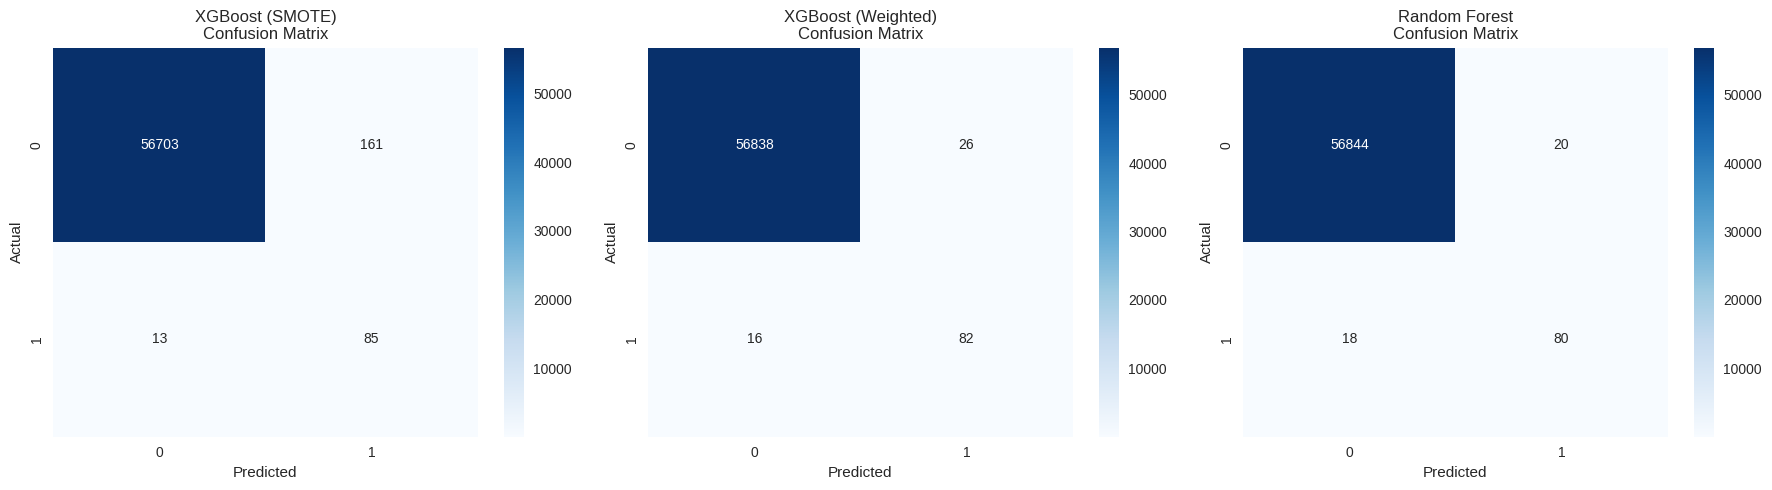

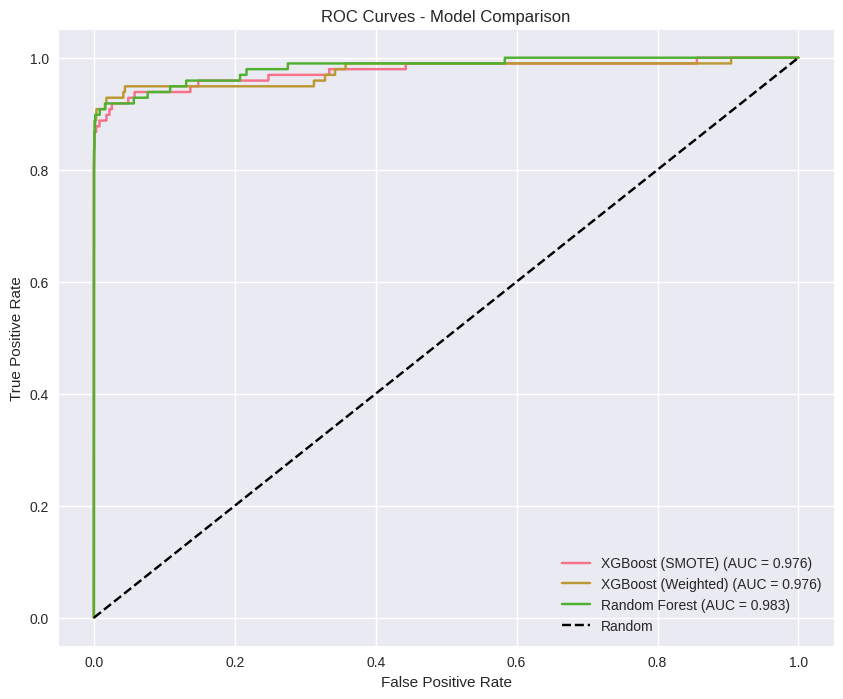

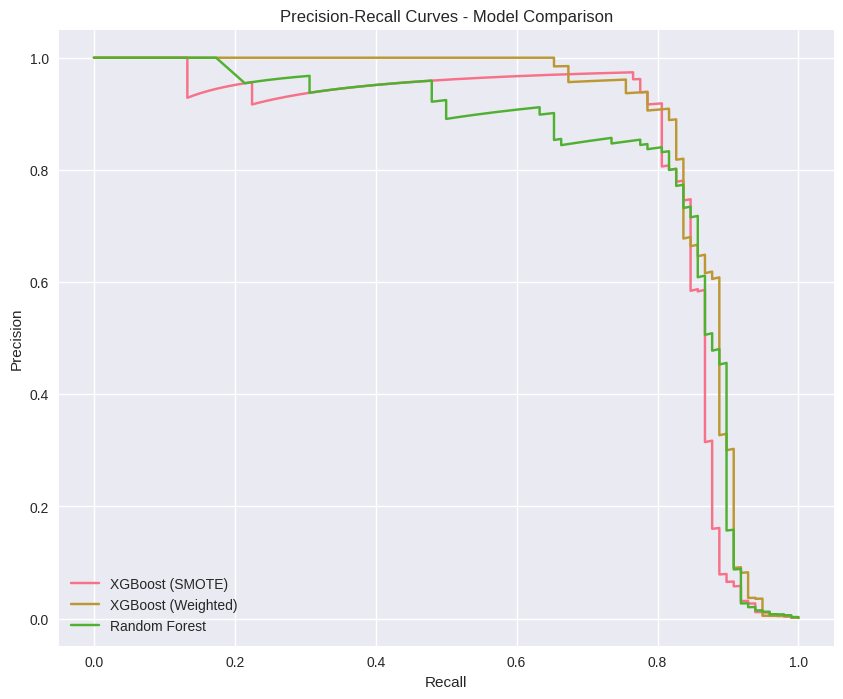

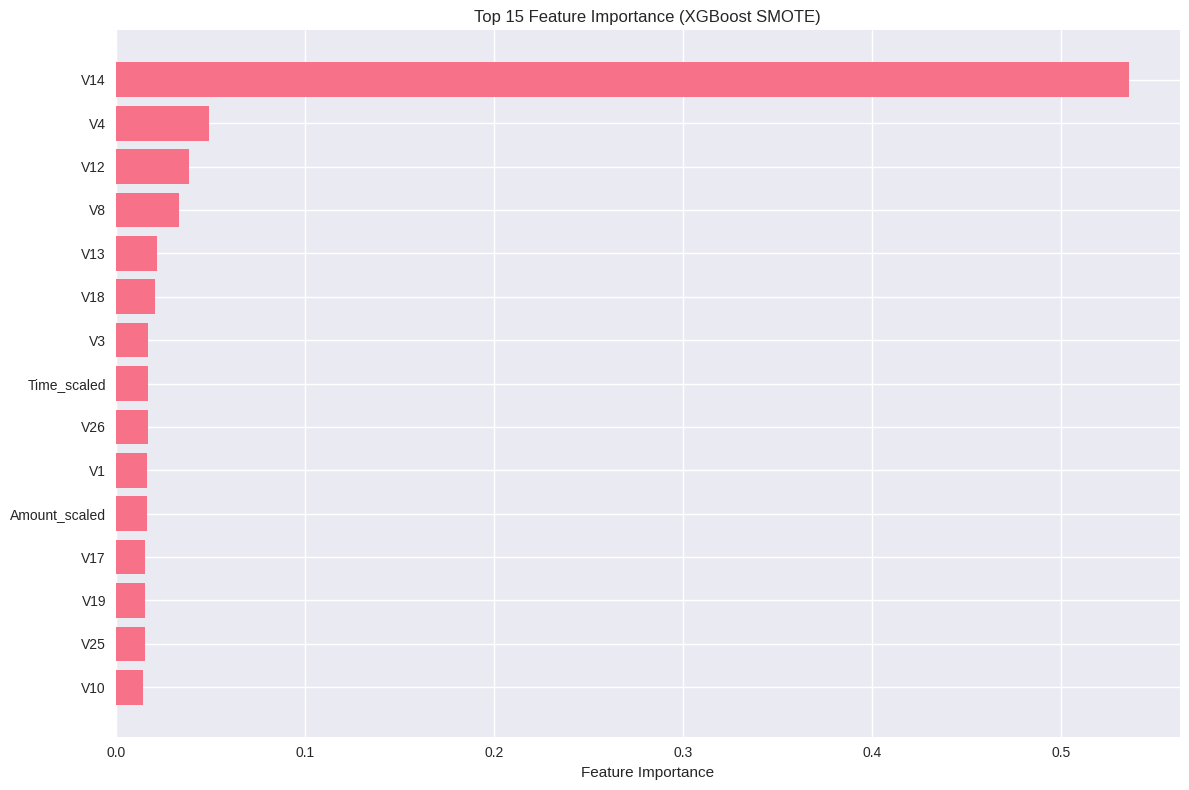

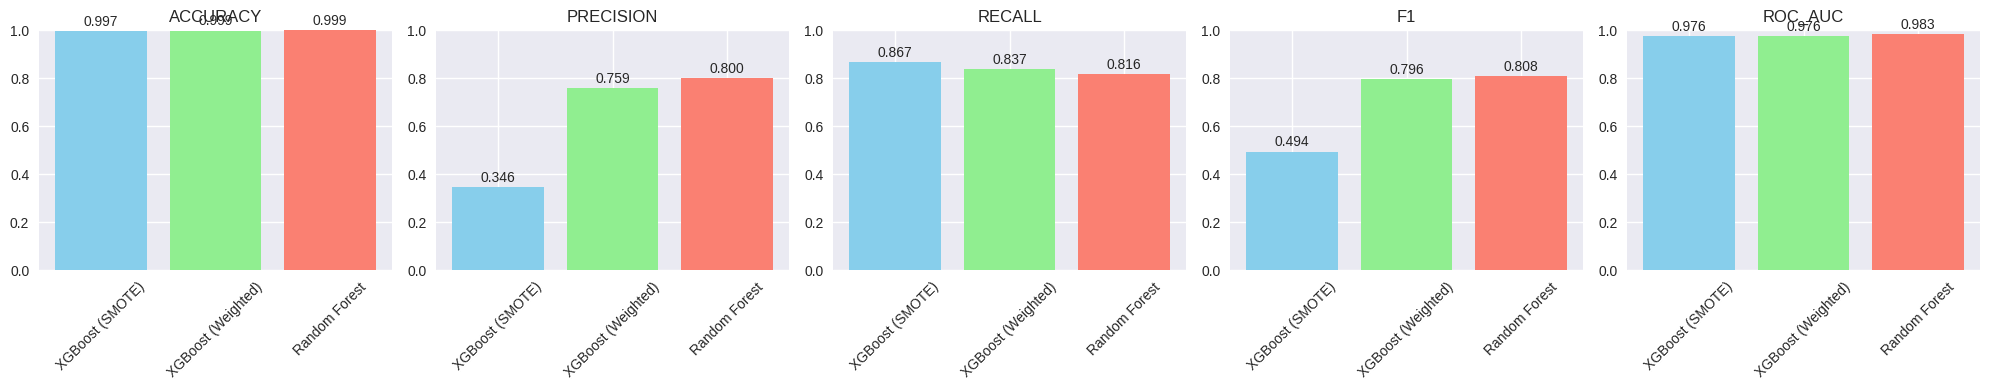

In [8]:
# SECTION 8: VISUALIZATIONS

print("\n" + "="*60)
print("SECTION 8: VISUALIZATIONS")
print("="*60)

# 1. Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [
    ("XGBoost (SMOTE)", y_pred_xgb_smote),
    ("XGBoost (Weighted)", y_pred_xgb_weighted),
    ("Random Forest", y_pred_rf)
]

for i, (name, pred) in enumerate(models):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{name}\nConfusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# 2. ROC Curves
plt.figure(figsize=(10, 8))

probas = [
    ("XGBoost (SMOTE)", y_pred_proba_xgb_smote),
    ("XGBoost (Weighted)", y_pred_proba_xgb_weighted),
    ("Random Forest", y_pred_proba_rf)
]

for name, proba in probas:
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc_score = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend()
plt.grid(True)
plt.show()

# 3. Precision-Recall Curves
plt.figure(figsize=(10, 8))

for name, proba in probas:
    precision, recall, _ = precision_recall_curve(y_test, proba)
    plt.plot(recall, precision, label=f'{name}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - Model Comparison')
plt.legend()
plt.grid(True)
plt.show()

# 4. Feature Importance (XGBoost SMOTE)
plt.figure(figsize=(12, 8))

feature_importance = xgb_smote.feature_importances_
feature_names = X_train.columns

# Get top 15 features
top_features_idx = np.argsort(feature_importance)[-15:]
top_features = feature_names[top_features_idx]
top_importance = feature_importance[top_features_idx]

plt.barh(range(len(top_features)), top_importance)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importance (XGBoost SMOTE)')
plt.tight_layout()
plt.show()

# 5. Model Performance Comparison
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
model_names = list(results.keys())

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, metric in enumerate(metrics):
    values = [results[model][metric] for model in model_names]
    axes[i].bar(model_names, values, color=['skyblue', 'lightgreen', 'salmon'])
    axes[i].set_title(f'{metric.upper()}')
    axes[i].set_ylim(0, 1)
    axes[i].tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for j, v in enumerate(values):
        axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [9]:
# SECTION 9: RESULTS SUMMARY

print("\n" + "="*60)
print("SECTION 9: RESULTS SUMMARY")
print("="*60)

# Create results summary table
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

print("📊 Model Performance Summary:")
print(results_df)

# Find best model for each metric
print(f"\n🏆 Best Models by Metric:")
for metric in results_df.columns:
    best_model = results_df[metric].idxmax()
    best_value = results_df[metric].max()
    print(f"   {metric.upper()}: {best_model} ({best_value:.4f})")


SECTION 9: RESULTS SUMMARY
📊 Model Performance Summary:
                    accuracy  precision  recall      f1  roc_auc
XGBoost (SMOTE)       0.9969     0.3455  0.8673  0.4942   0.9760
XGBoost (Weighted)    0.9993     0.7593  0.8367  0.7961   0.9758
Random Forest         0.9993     0.8000  0.8163  0.8081   0.9827

🏆 Best Models by Metric:
   ACCURACY: XGBoost (Weighted) (0.9993)
   PRECISION: Random Forest (0.8000)
   RECALL: XGBoost (SMOTE) (0.8673)
   F1: Random Forest (0.8081)
   ROC_AUC: Random Forest (0.9827)
